In [1]:
# General modules
import sys
import os
import session_info
import warnings
from pyprojroot.here import here
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import plotly.graph_objects as go
import re
import io

# Specific modules
import scanpy as sc
import anndata as ad
import scienceplots
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Patch
import plotly.io as pio

# Setting some parameters
warnings.filterwarnings("ignore")

# Import functions
sys.path.insert(1, str(here('bin')))
from customPalette import *

plt.style.use(['nature'])
dpi_fig_save = 300
sc.set_figure_params(dpi=100, dpi_save=dpi_fig_save, vector_friendly=True)

overwriteFigures = True
overwriteData = True

pd.options.display.max_columns = 300
pd.options.display.max_rows = 1000

**Defining functions**

In [2]:
print("directory path: {}".format(here()))

directory path: /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas-R1


In [3]:
#### We want to explore data characteristics ACROSS only VALIDATION? also VALDIATION / EXCLUDED / EXTERNAL?

**Load data**

In [4]:
# Load the annotated file
adata_core = sc.read_h5ad(here("01_data_processing/results/02_INFLAMMATION_core_afterQC.h5ad"))
adata_core.uns['log1p'] = dict()
adata_core.uns['log1p']['base'] = None # only if logscale is computed
adata_core

AnnData object with n_obs × n_vars = 5768062 × 22838
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'doublet_score', 'predicted_doublet'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'chemistry_colors', 'log1p'

In [5]:
# Load the annotated file
adata_ext = sc.read_h5ad(here("01_data_processing/results/02_INFLAMMATION_external_afterQC.h5ad"))
adata_ext.uns['log1p'] = dict()
adata_ext.uns['log1p']['base'] = None # only if logscale is computed
adata_ext

AnnData object with n_obs × n_vars = 572872 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'chemistry_colors', 'log1p'

In [6]:
# Merge datasets AFTER QC, but not annotated (therefore not fully clean)
adata = ad.concat([adata_core, adata_ext], join='outer', merge='unique')
adata

AnnData object with n_obs × n_vars = 6340934 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'doublet_score', 'predicted_doublet'

In [7]:
len(adata.obs["patientID"].unique())

1047

# Cell exploration

In [15]:
# Alternatively, if you want to get the counts of unique values in each group
obs_df = adata.obs
obs_df.groupby('disease').size()

disease
BRCA           38117
CD            186663
COPD           75855
COVID         879513
CRC           105099
HBV           102859
HIV            47837
HNSCC          46843
MS             25421
NPC           103003
PS            186399
PSA           158958
RA            498799
SLE           823344
UC            129932
asthma         80822
cirrhosis     177572
flu            19029
healthy      2454604
sepsis        200265
dtype: int64

# Patient exploration

In [8]:
obs_df = adata.obs
obs_df = obs_df[['studyID', 'patientID', 'chemistry', 'technology', 'binned_age', 'sex', 'disease']].drop_duplicates() # removing LIBRARY (sampleID in multiple)
obs_df = obs_df.reset_index(drop=True)
obs_df["studyID_disease"] =  obs_df["disease"].str.cat(obs_df["studyID"], sep="_")
obs_df = obs_df.sort_values(by="studyID_disease")
obs_df.head()

,studyID,patientID,chemistry,technology,binned_age,sex,disease,studyID_disease
228,SCGT03,SCGT03_560,5_GEX_V2,5_GEX_V2,51-60,female,BRCA,BRCA_SCGT03
227,SCGT03,SCGT03_497,5_GEX_V2,5_GEX_V2,41-50,female,BRCA,BRCA_SCGT03
226,SCGT03,SCGT03_474,5_GEX_V2,5_GEX_V2,51-60,female,BRCA,BRCA_SCGT03
225,SCGT03,SCGT03_571,5_GEX_V2,5_GEX_V2,31-40,female,BRCA,BRCA_SCGT03
223,SCGT03,SCGT03_473,5_GEX_V2,5_GEX_V2,31-40,female,BRCA,BRCA_SCGT03


In [62]:
obs_df['sex'] = obs_df['sex'].fillna('na')
obs_df['sex'] = pd.Categorical(obs_df['sex'], categories=['male', 'female', 'na'])
obs_df['binned_age'] = obs_df['binned_age'].fillna('unknown')
obs_df['binned_age'] = pd.Categorical(obs_df['binned_age'], categories=['<18',  '18-30', '31-40', '41-50', '51-60','61-70', '71-80', '>80', 'unknown'])

# Replace 
obs_df['studyID'] = obs_df['studyID'].replace('Zhang2023', 'Zhang2022')

obs_df['disease'] = obs_df['disease'].astype(str)
obs_df['patientID'] = obs_df['patientID'].astype(str)

# Calculate total patientID by disease
total_patientID_by_disease = obs_df.groupby('disease')['patientID'].count().reset_index()
total_patientID_by_disease.columns = ['disease', 'total_patientID']

# Merge total_patientID_by_disease back to obs_df
obs_df = pd.merge(obs_df, total_patientID_by_disease, on='disease')

# Mapping diseases to diseaseGroup
obs_df['diseaseGroup'] = obs_df['disease'].map(diseaseCategories)
obs_df['diseaseGroup'] = pd.Categorical(obs_df['diseaseGroup'], categories=diseaseGroup_sortednames, ordered=True)

# Sort obs_df by diseaseGroup in the order specified by diseaseGroup_sortednames, and then by total_patientID ascending
obs_df = obs_df.sort_values(by=['diseaseGroup', 'total_patientID'], ascending=[True, False])

# Convert disease to categorical with the correct order
obs_df['disease'] = pd.Categorical(obs_df['disease'], categories=obs_df['disease'].unique())

# Reset index inplace
obs_df.reset_index(drop=True, inplace=True)


# Reset index inplace
obs_df.reset_index(drop=True, inplace=True)

In [63]:
# Helper function to calculate percentages
def calculate_percentage(df, group_by_cols):
    count_data = df.groupby(group_by_cols).size().reset_index(name='Patient Count')
    total_counts = count_data.groupby(group_by_cols[0])['Patient Count'].transform('sum')
    count_data['Percentage'] = (count_data['Patient Count'] / total_counts) * 100
    return count_data

# Plotting function for stacked bar plots with percentages
def plot_percentage_stacked_bar(ax, x, y, data, title, palette, **kwargs):
    # Pivot the data
    pivot_data = data.pivot_table(index=y, columns=x, values='Percentage', fill_value=0)

    # Extract bar height from kwargs or set a default value
    bar_height = kwargs.pop('height', 0.8)

    # Plot the data with specified bar height
    left = np.zeros(len(pivot_data))
    legend_handles = []
    for column in pivot_data.columns:
        ax.barh(pivot_data.index, pivot_data[column], left=left, height=bar_height, label=column, color=palette[column], **kwargs)
        left += pivot_data[column]
        legend_handles.append(Patch(facecolor=palette[column], edgecolor='black', label=column))
        
    # Set the title and labels
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('' if ax != axes[0] else 'Disease')

    # Remove grid
    ax.tick_params(axis='both', which='both', length=0)
    ax.tick_params(axis='x', rotation=90)
    ax.yaxis.grid(False)

    # Set legend
    ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=2, frameon=False, handles=legend_handles)

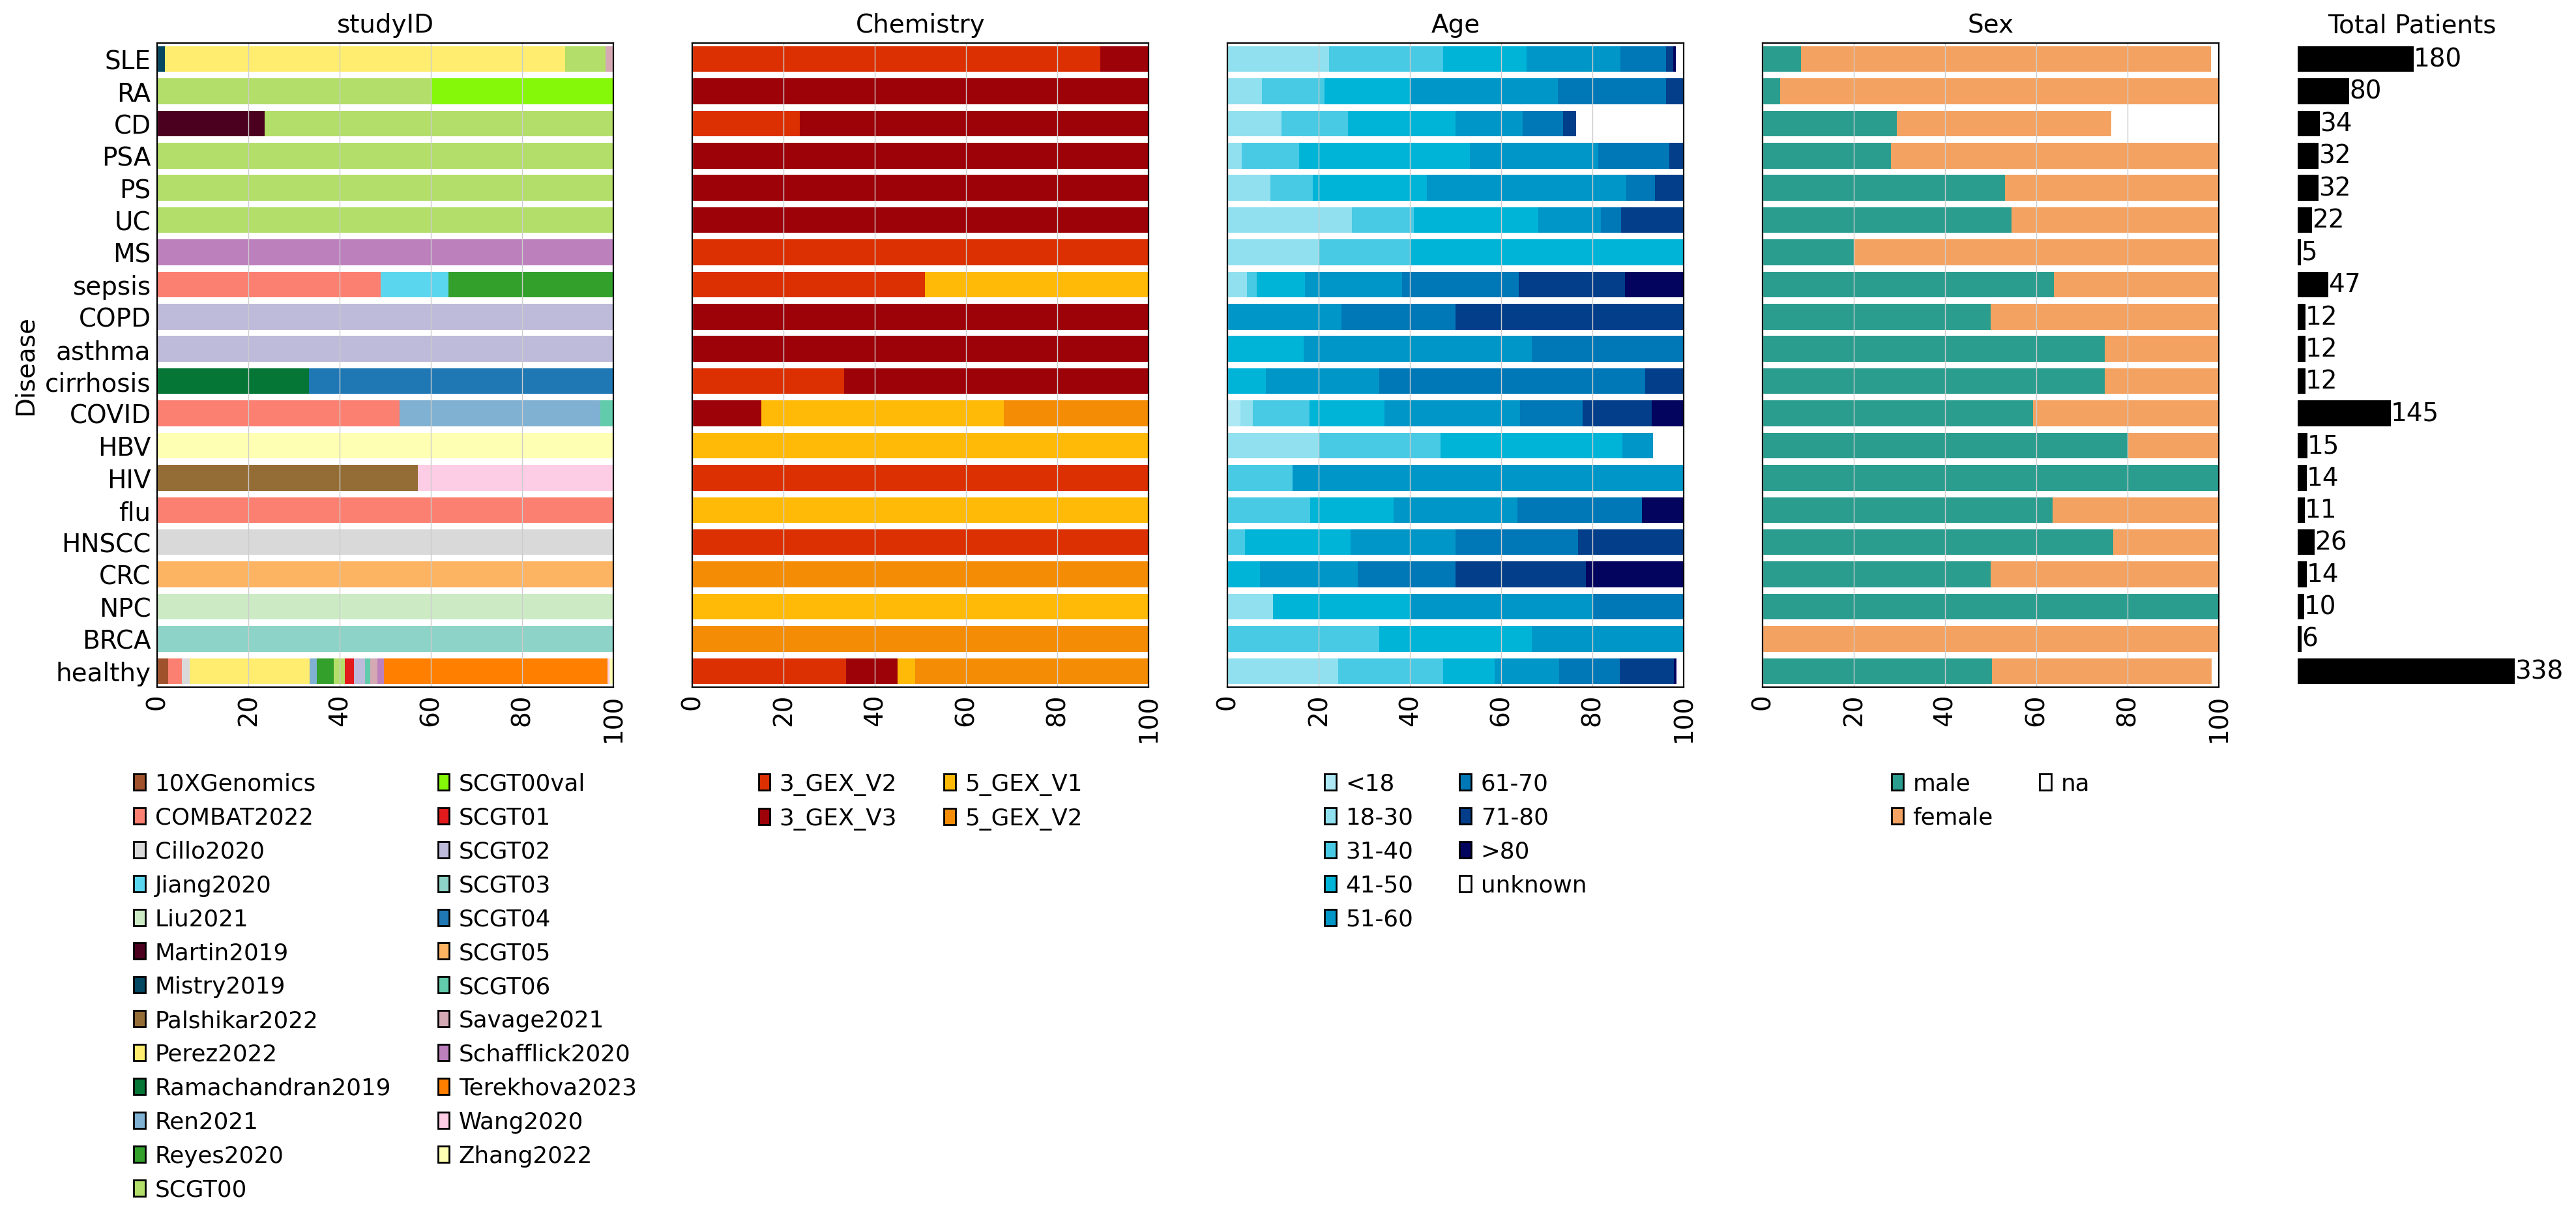

In [64]:
# Calculate percentages
agg_data_studyID = calculate_percentage(obs_df, ['disease', 'studyID'])
agg_data_chemistry = calculate_percentage(obs_df, ['disease', 'chemistry'])
agg_data_binned_age = calculate_percentage(obs_df, ['disease', 'binned_age'])
agg_data_sex = calculate_percentage(obs_df, ['disease', 'sex'])
total_per_disease = obs_df.groupby('disease').size().reset_index(name='Total Patients')

# Create a figure and subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 10), sharey=True, 
                         gridspec_kw={'width_ratios': [3, 3, 3, 3, 1.5]})

# Plot stacked bar plots for each category
plot_percentage_stacked_bar(axes[0], 'studyID', 'disease', agg_data_studyID, 'studyID', palette=studyID_palette)
plot_percentage_stacked_bar(axes[1], 'chemistry', 'disease', agg_data_chemistry, 'Chemistry', palette=chemistry_palette)
plot_percentage_stacked_bar(axes[2], 'binned_age', 'disease', agg_data_binned_age, 'Age', palette=binned_age_palette)
plot_percentage_stacked_bar(axes[3], 'sex', 'disease', agg_data_sex, 'Sex', palette=sex_palette)

# Plot total patients per disease
sns.barplot(ax=axes[4], x='Total Patients', y='disease', data=total_per_disease, orient='h', color="black")
axes[4].set_title('Total Patients')
axes[4].bar_label(axes[4].containers[0])
axes[4].axis('off')

# Adjust layout
plt.tight_layout(w_pad=0, h_pad=0.1)
plt.show()

fig.savefig(here(f"01_data_processing/figures/USEDdata_ClinicalMetadata_overview.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)

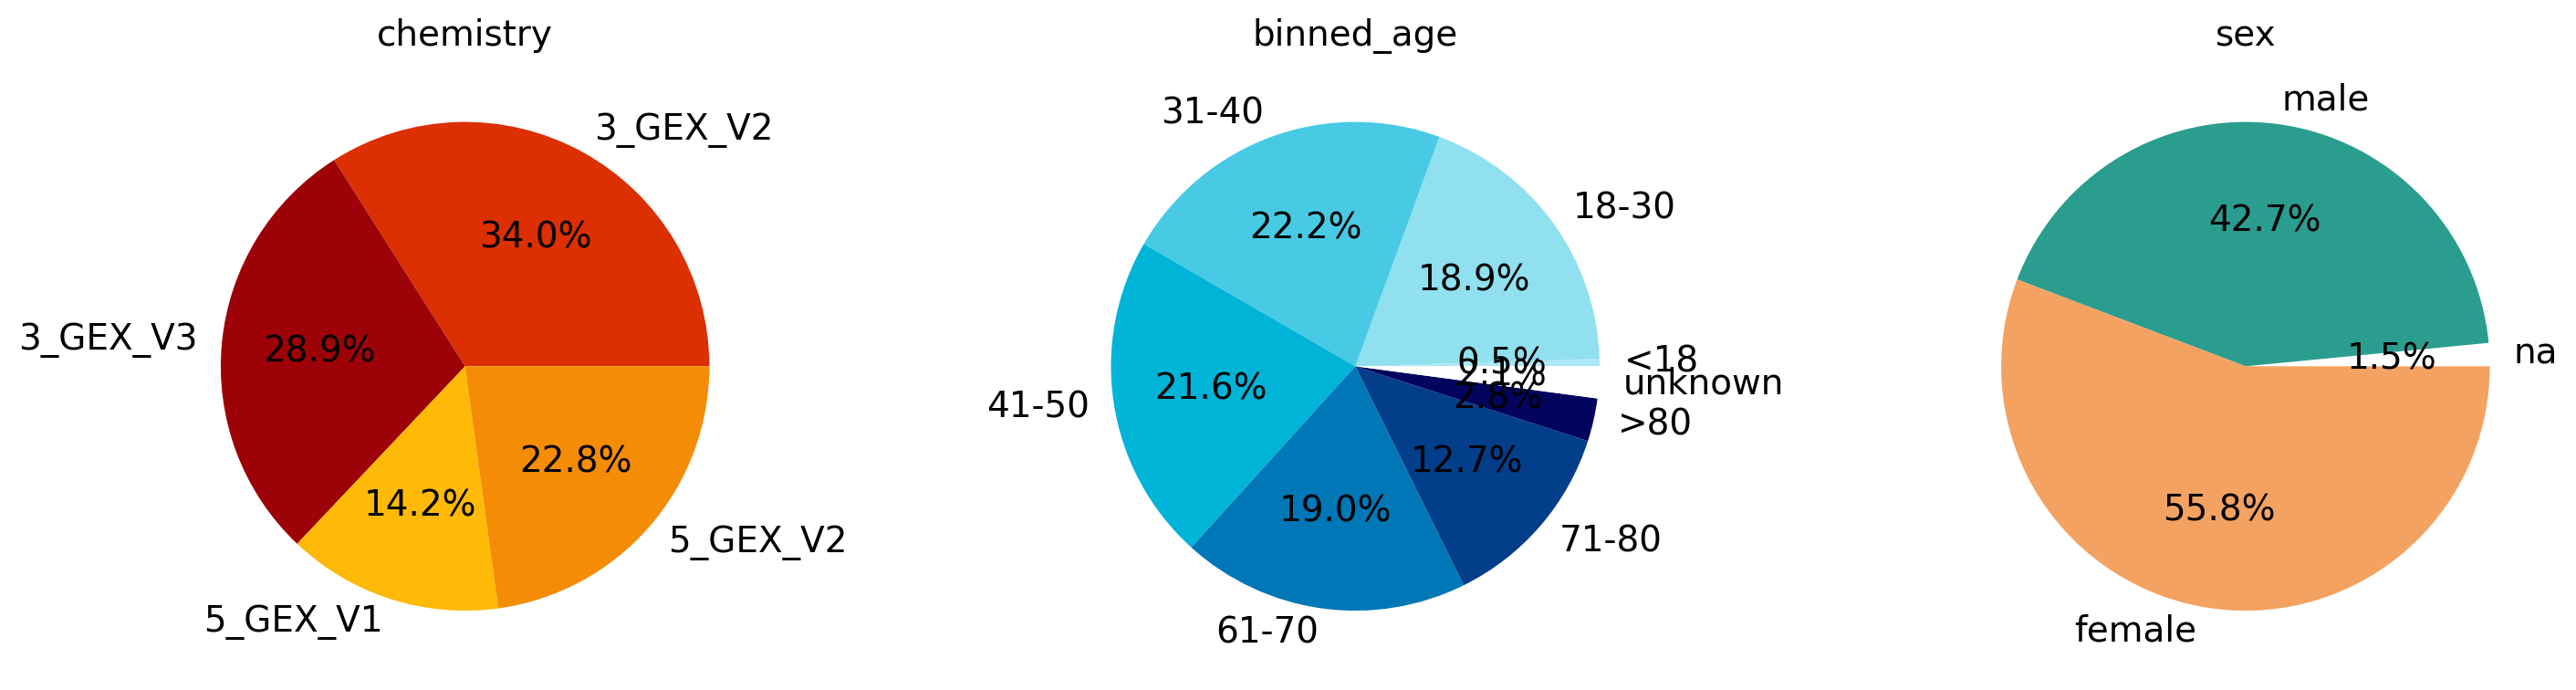

In [68]:
# PieChart for CHEMISTRY, BINNED_AGE and SEX

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

dic_palette = {"chemistry" : chemistry_palette, 
               "binned_age" : binned_age_palette, 
               "sex" : sex_palette   
}

# Data for each value count
for i, variable in enumerate(["chemistry", "binned_age", "sex"]):
    if variable == "binned_age":
        category_order = ['<18', '18-30', '31-40', '41-50', '61-70', '71-80', '>80', 'unknown']
    else:
        category_order = obs_df[variable].unique()
    counts = obs_df[variable].value_counts().reindex(pd.Categorical(category_order, categories=category_order))
    labels = counts.index.to_list()
    axes[i].pie(counts, colors = [dic_palette[variable][label] for label in labels], labels=counts.index, autopct='%1.1f%%')
    axes[i].set_title(variable)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

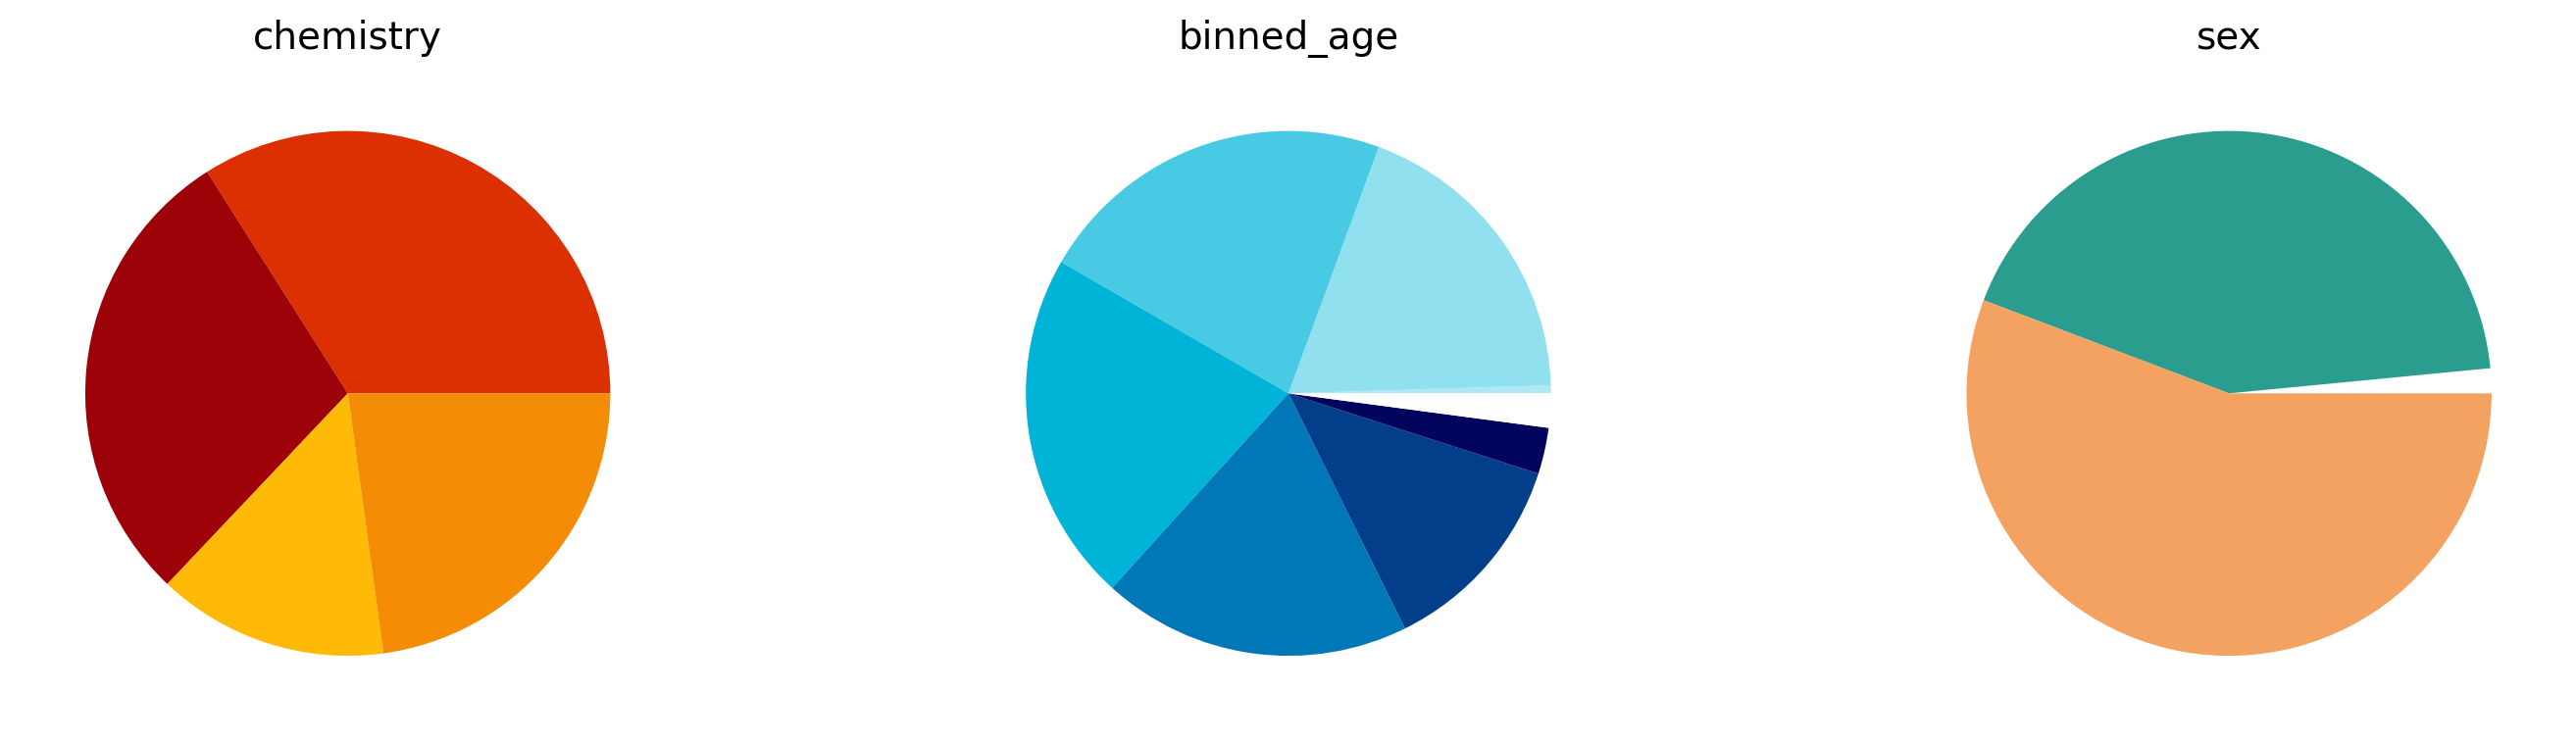

In [69]:
# PieChart for CHEMISTRY, BINNED_AGE and SEX

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

dic_palette = {"chemistry" : chemistry_palette, 
               "binned_age" : binned_age_palette, 
               "sex" : sex_palette   
}

# Data for each value count
for i, variable in enumerate(["chemistry", "binned_age", "sex"]):
    if variable == "binned_age":
        category_order = ['<18', '18-30', '31-40', '41-50', '61-70', '71-80', '>80', 'unknown']
    else:
        category_order = obs_df[variable].unique()
    counts = obs_df[variable].value_counts().reindex(pd.Categorical(category_order, categories=category_order))
    labels = counts.index.to_list()
    axes[i].pie(counts, colors = [dic_palette[variable][label] for label in labels])
    axes[i].set_title(variable)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

fig.savefig(here(f"01_data_processing/figures/USEDdata_ClinicalMetadata_piechart.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)

In [13]:
session_info.show()